In [1]:
import pickle
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import json
from tqdm import tqdm

In [11]:
import os
import json
import numpy as np
from tqdm import tqdm

data_dir = '/scratch/cpk286/datasets/data_original'

X_list = []
y_list = []

# Iterate through the experiments
for expt in tqdm(sorted(os.listdir(data_dir))):
    experiment_scan = os.path.join(data_dir, expt)
    
    # load mask values
    mask_path = os.path.join(experiment_scan, 'mask.json')
    with open(mask_path, 'r') as f:
        mask = json.load(f)
    
    # Load the feature vectors
    feature_path = os.path.join(experiment_scan, 'features.npy')
    if os.path.exists(feature_path):
        features = np.load(feature_path)  # Shape: (n_windows, 7000)
    else:
        print(f"Feature file missing for {experiment_scan}")
        continue
    
    # Alignment
    for window_id, feature_vector in enumerate(features):
        label_key = f"sample_{window_id + 1}"  # Keys in the mask.json
        if label_key in mask:
            X_list.append(feature_vector)  # Append the feature vector (7000-length)
            y_list.append(mask[label_key])  # Append the corresponding mask values (length 1000)
            # trace_list.append(trace[label_key])
        else:
            print(f"Missing label for {label_key} in {mask_path}")

X_data = np.array(X_list)  
y_data = np.array(y_list)  
# trace_data = np.array(trace_list)

# Check shapes
print(f"Number of feature vectors: {X_data.shape}")
print(f"Number of labels: {y_data.shape}")


100%|██████████| 159/159 [00:05<00:00, 29.08it/s]

Number of feature vectors: (999951, 7)
Number of labels: (999951,)


In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print(f"Training data shape: {X_train_scaled.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test_scaled.shape}, Labels shape: {y_test.shape}")

Training data shape: (799960, 7), Labels shape: (799960,)
Testing data shape: (199991, 7), Labels shape: (199991,)


In [14]:
X_train[:10]

array([[-29.09225578, -29.34787844, -55.14729057, -72.72216619,
        -73.5022019 , -80.        , -80.        ],
       [-31.58708556, -31.84262687, -56.72699043, -72.90661305,
        -73.67587478, -80.        , -80.        ],
       [-16.8877761 , -17.14374477, -69.31695861, -80.        ,
        -80.        , -80.        , -80.        ],
       [-28.12236753, -28.37813271, -56.47619037, -71.21522867,
        -71.97479242, -78.50356241, -80.        ],
       [-30.59653846, -30.85087034, -49.90984231, -65.7281623 ,
        -66.49639496, -73.28829868, -80.        ],
       [-32.0368072 , -32.29205346, -54.90002231, -73.13779139,
        -73.92436574, -80.        , -80.        ],
       [-19.28217657, -19.53812235, -56.99325788, -73.67507902,
        -74.45029987, -80.        , -80.        ],
       [-29.49041313, -29.7463765 , -73.09368583, -80.        ,
        -80.        , -80.        , -80.        ],
       [-42.57136257, -42.82377047, -58.50932804, -76.78235374,
        -77.5675

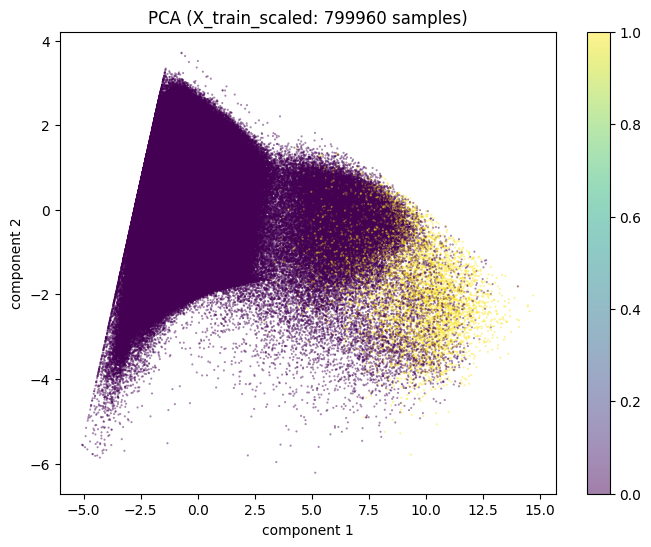

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, alpha=0.5, marker=".", s = 1)
plt.colorbar()
plt.title(f'PCA (X_train_scaled: {X_train_scaled.shape[0]} samples)')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()



In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_test, alpha=0.5, marker=".", s = 1)
plt.colorbar()
plt.title(f'PCA (X_train_scaled: {X_test_scaled.shape[0]} samples)')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()



NameError: name 'y_pred_test' is not defined

<Figure size 800x600 with 0 Axes>

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(128, 64),  # Two hidden layers with 128 and 64 neurons
                    activation='relu',
                    solver='adam',
                    max_iter=200,
                    tol=1e-4,
                    random_state=42)

mlp.fit(X_train_scaled, y_train)
print("Training complete")

Training complete


In [19]:
y_pred_train = mlp.predict(X_train_scaled)
y_pred_test = mlp.predict(X_test_scaled)

print("\nTraining Performance:")
print(classification_report(y_train, y_pred_train))
print("\nTesting Performance:")
print(classification_report(y_test, y_pred_test))


Training Performance:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    793654
         1.0       0.76      0.64      0.70      6306

    accuracy                           1.00    799960
   macro avg       0.88      0.82      0.85    799960
weighted avg       1.00      1.00      1.00    799960


Testing Performance:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    198415
         1.0       0.76      0.64      0.69      1576

    accuracy                           1.00    199991
   macro avg       0.88      0.82      0.85    199991
weighted avg       1.00      1.00      1.00    199991



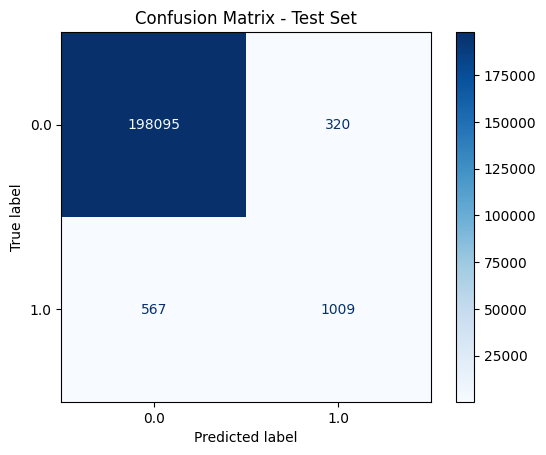

In [20]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Test Set")
plt.show()

In [21]:
# save model
model_filename = "/home/cpk286/NF-Volt/models/mlp_1M_imb.pkl"
with open(model_filename, "wb") as model_file:
    pickle.dump(mlp, model_file)